In [1]:
import numpy as np
import pandas as pd
import string
import nltk
import re
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\waqar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\waqar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\waqar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\waqar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Load the dataset
dataset = pd.read_csv("twitter_training.csv")
dataset_val = pd.read_csv("twitter_validation.csv")

# Rename column headers
dataset.columns = ['ID', 'Entity', 'Sentiment', 'Context']
dataset_val.columns = ['ID', 'Entity', 'Sentiment', 'Context']

# Drop unnecessary columns
new_dataset = dataset[['Sentiment', 'Context']]
new_dataset_val = dataset_val[['Sentiment', 'Context']]

# Handle missing values
new_dataset = new_dataset.dropna(subset=['Context'])
new_dataset_val = new_dataset_val.dropna(subset=['Context'])

# Convert non-string values to empty strings
new_dataset['Context'] = new_dataset['Context'].astype(str)
new_dataset_val['Context'] = new_dataset_val['Context'].astype(str)

In [4]:
# Data cleaning and preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stop_words])

def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV,
        'J': wordnet.ADJ
    }
    pos_text = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])

new_dataset['Context'] = new_dataset['Context'].apply(lambda x: clean_text(x))
new_dataset_val['Context'] = new_dataset_val['Context'].apply(lambda x: clean_text(x))

new_dataset['Context'] = new_dataset['Context'].apply(lambda x: remove_stopwords(x))
new_dataset_val['Context'] = new_dataset_val['Context'].apply(lambda x: remove_stopwords(x))

new_dataset['Context'] = new_dataset['Context'].apply(lambda x: stem_words(x))
new_dataset_val['Context'] = new_dataset_val['Context'].apply(lambda x: stem_words(x))

new_dataset['Context'] = new_dataset['Context'].apply(lambda x: lemmatize_words(x))
new_dataset_val['Context'] = new_dataset_val['Context'].apply(lambda x: lemmatize_words(x))


In [5]:
# Tokenization and padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(new_dataset['Context'])

sequences_train = tokenizer.texts_to_sequences(new_dataset['Context'])
sequences_val = tokenizer.texts_to_sequences(new_dataset_val['Context'])

X_train_pad = pad_sequences(sequences_train, maxlen=max_len)
X_val_pad = pad_sequences(sequences_val, maxlen=max_len)

# Label encoding
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(new_dataset['Sentiment'])
y_val_encoded = label_encoder.transform(new_dataset_val['Sentiment'])
num_classes = np.max(y_train_encoded) + 1

In [6]:
# Model architecture
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Epoch 1/20
1157/1157 [==============================] - 133s 111ms/step - loss: 0.9856 - accuracy: 0.5964 - val_loss: 0.6030 - val_accuracy: 0.7848
Epoch 2/20
1157/1157 [==============================] - 168s 145ms/step - loss: 0.6753 - accuracy: 0.7480 - val_loss: 0.4210 - val_accuracy: 0.8629
Epoch 3/20
1157/1157 [==============================] - 129s 111ms/step - loss: 0.5306 - accuracy: 0.8042 - val_loss: 0.3656 - val_accuracy: 0.8859
Epoch 4/20
1157/1157 [==============================] - 129s 111ms/step - loss: 0.4372 - accuracy: 0.8377 - val_loss: 0.3872 - val_accuracy: 0.9009
Epoch 5/20
1157/1157 [==============================] - 162s 140ms/step - loss: 0.3726 - accuracy: 0.8626 - val_loss: 0.3762 - val_accuracy: 0.9049
Epoch 6/20
1157/1157 [==============================] - 135s 116ms/step - loss: 0.3282 - accuracy: 0.8771 - val_loss: 0.4268 - val_accuracy: 0.8909
Epoch 7/20
1157/1157 [==============================] - 136s 118ms/step - loss: 0.2884 - accuracy: 0.8922 - val_

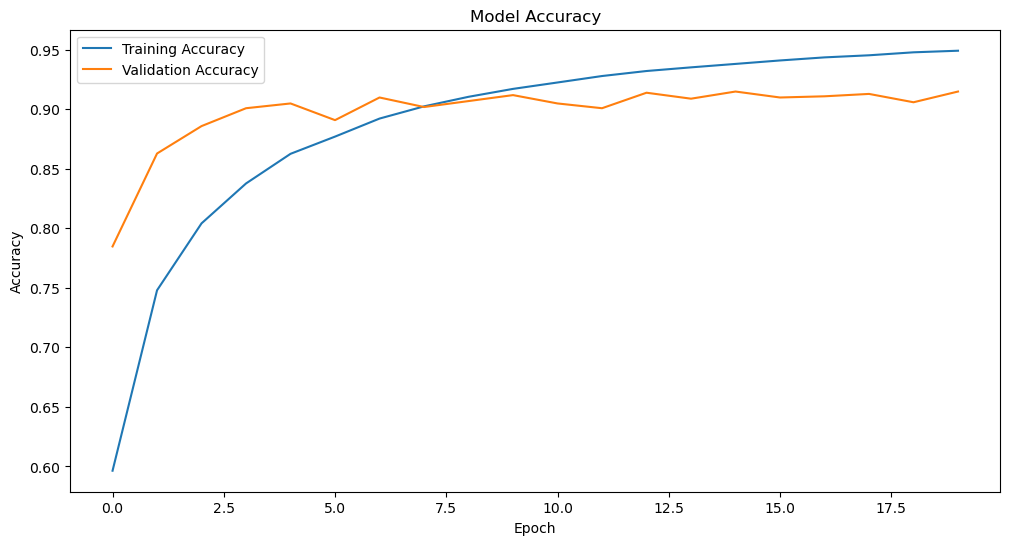

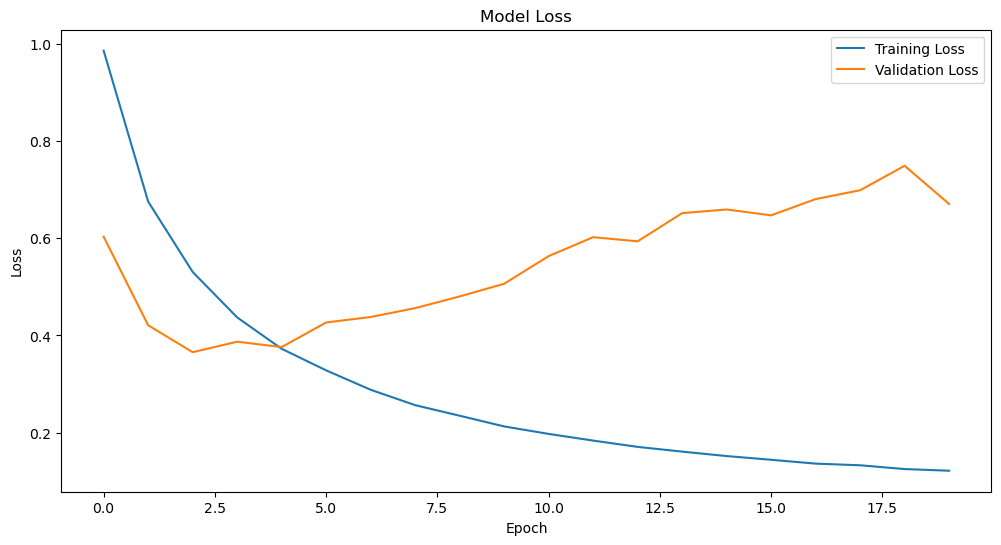

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
history = model.fit(X_train_pad, to_categorical(y_train_encoded),
                    validation_data=(X_val_pad, to_categorical(y_val_encoded)),
                    epochs=20, batch_size=64, verbose=1)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
import pickle

# Saving the tokenizer and label encoder
with open('tokenizer_new.pickle', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

with open('label_encoder_new.pkl', 'wb') as label_encoder_file:
    pickle.dump(label_encoder, label_encoder_file)

# Saving the model architecture and weights
model.save('text_classification_model_new.h5')
